In [1]:
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from RegscorePy import *
from collections import OrderedDict
# import pymc3 as pm

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [2]:
def combine_deep_fields(fields, csfq, ssfq, masscut_low, masscut_high, z, path, sat_z_cut, sample='',bin_number=14):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
    affix = '_'+sample+str(sat_z_cut)+'_'+ str(masscut_low)+'_'+ str(masscut_high) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'.txt'
    affix_old = '_'+sample+ str(masscut_low)+ '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'.txt'
    
    radial_combine = np.zeros(bin_number)
    radial_err_combine =  np.zeros(bin_number)
    n_fields = []
    for field in fields:
        try:
            data_field = np.genfromtxt(path+'count'+field+affix)
        except OSError:
            data_field = np.genfromtxt(path+'count'+field+affix_old)
            
        split_index = int(((len(data_field)-1)/2)+1)
        n_field = data_field[0]
        radial_field = data_field[1:split_index]
        radial_field_err = data_field[split_index:]
        
        n_fields.append(n_field)
        radial_combine = np.vstack([radial_combine, radial_field])
        radial_err_combine = np.vstack([radial_err_combine, radial_field_err*n_field])
        
    # remove the zeros line
    radial_combine = radial_combine[1:,:]
    radial_err_combine = radial_err_combine[1:,:]
    
    n_tot = sum(n_fields)   
    radial = np.average(radial_combine, axis=0, weights=n_fields)
    radial_err = np.sqrt(sum(radial_err_combine**2))/sum(n_fields)
    return (radial, radial_err, n_tot)

def load_deep(field_name, csfq, ssfq, masscut_low, masscut_high, z, path, sample=''):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
            
    affix = '_' + sample + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'.txt'
    field_deep = np.genfromtxt(path+'count'+field_name+affix)
    n_field = int(field_deep[0])
    
    split_index = int(((len(field_deep)-1)/2)+1)
    radial_field = field_deep[1:split_index]
    radial_field_err = field_deep[split_index:]
    return (radial_field, radial_field_err, n_field)

In [3]:
bin_number=14
bin_edges_areas = 10 ** np.linspace(1.0, np.log10(700), num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges_areas[:-1])):
    areas = np.append(areas, (bin_edges_areas[i + 1] ** 2 - bin_edges_areas[i] ** 2) * np.pi)
    

### Sersic + NFW model

NFW model

Sersic model

In [4]:
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def fit_nfw(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    
    res = ydata - nfw(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

def sersic(r,Ie,re,n):
#     n=5.5
    b=2*n-1./3
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic

def nfw_sersic(r, rs, I, Ie,re, n):
    sersic_val = sersic(r,Ie,re,n)
    nfw_val = nfw(r,rs,I)
    return nfw_val + sersic_val

def fit_nfw_sersic(xdata, ydata, ydata_err, start,end=-1):
    xdata = xdata[start-1:end]
    ydata = ydata[start-1:end]
    ydata_err = ydata_err[start-1:end]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,3e-5,4.2e-5,15.1, 5.5]
                          ,bounds=([0, 0, 0 ,0 ,0],[10000, 2e-2, 2e-2, 300, 40]),maxfev=10000)
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

def fit_nfw_sersic_fix_n(xdata, ydata, ydata_err, start,fix_n=0.26):
    xdata = xdata[start-1:]
    ydata = ydata[start-1:]
    ydata_err = ydata_err[start-1:]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,3e-5,4.2e-5,15.1, 0.26]
                          ,bounds=([0, 0, 0 ,0 ,fix_n-0.001],[10000, 2e-2, 2e-2, 300, fix_n+0.001]),maxfev=10000)
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

def red_frac_err_new(q, All, q_err, all_err):
    return np.sqrt( q_err**2*(1/All)**2 + all_err**2*(q/All**2)**2)

### Total Satellite Sample
### staticstics on satellites / background level


151
ELAIS_deep 0.4 sat 12.377 6.409
ELAIS_deep 0.4 bkg 8.364 1.056
144
DEEP_deep 0.4 sat 12.764 6.272
DEEP_deep 0.4 bkg 9.424 1.804
143
COSMOS_deep 0.4 sat 14.035 7.23
COSMOS_deep 0.4 bkg 9.664 1.294
159
XMM-LSS_deep 0.4 sat 14.296 8.2
XMM-LSS_deep 0.4 bkg 9.296 0.804

116
ELAIS_deep 0.6 sat 18.569 7.914
ELAIS_deep 0.6 bkg 13.371 1.54
163
DEEP_deep 0.6 sat 16.055 6.334
DEEP_deep 0.6 bkg 12.89 1.243
177
COSMOS_deep 0.6 sat 16.706 7.275
COSMOS_deep 0.6 bkg 12.079 1.496
236
XMM-LSS_deep 0.6 sat 13.119 6.644
XMM-LSS_deep 0.6 bkg 9.237 1.014

403
ELAIS_deep 0.8 sat 18.452 7.288
ELAIS_deep 0.8 bkg 13.841 0.472
314
DEEP_deep 0.8 sat 17.124 6.857
DEEP_deep 0.8 bkg 12.268 1.164
353
COSMOS_deep 0.8 sat 19.626 8.589
COSMOS_deep 0.8 bkg 14.513 1.215
421
XMM-LSS_deep 0.8 sat 14.786 8.026
XMM-LSS_deep 0.8 bkg 10.221 0.837


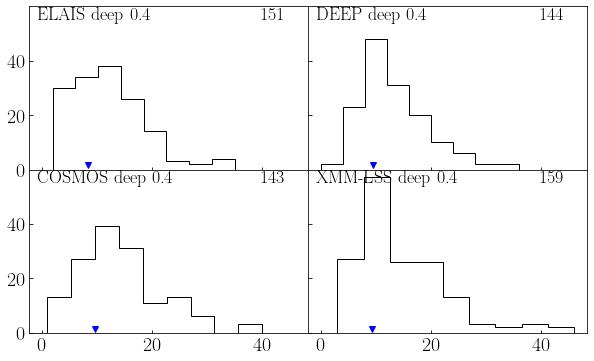

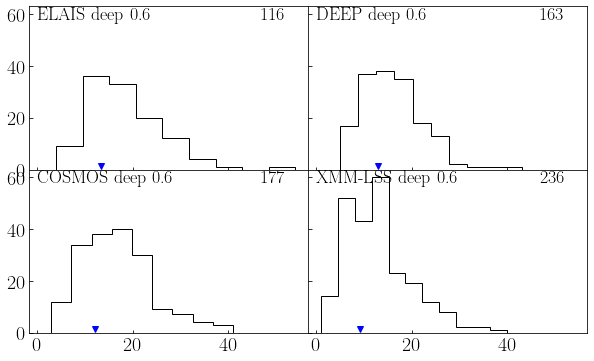

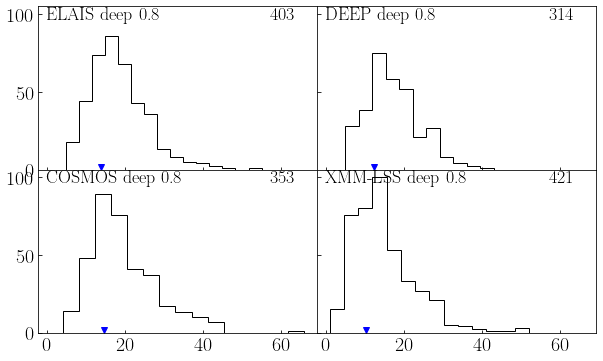

In [5]:
# satellite counts
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
count_sat = []
sat_z_cut=3.0

for z in [0.4,0.6,0.8]:
    print('')
    fig, axs = plt.subplots(2, 2, figsize = (10, 6),sharex=True,sharey=True)
    for i,field_name in enumerate(field_names):
        row=i//2
        col=i%2
        cat = Table.read('CUT_deep_catalogs/radial_dist_code/central_cat/isolated_'+field_name+'_'+str(sat_z_cut)+'_11.3_'+str(z)+'_massive.positions.fits')
        #print bkg level and median satellite number
        print('============')
        print(len(cat))
        print(field_name,z,'sat', round(np.mean(cat['n_sat']),3),round(np.std(cat['n_sat']),3))
        print(field_name,z,'bkg', round(np.mean(cat['n_bkg']),3),round(np.std(cat['n_bkg']),3))
        
        # plot histogram
        axs[row][col].hist(cat['n_sat'],histtype='step',color='k',bins='scott')
        axs[row][col].plot(np.mean(cat['n_bkg']),1.5,'vb')
        
        # annotations
        axs[row][col].annotate(field_name.replace('_',' ')+' '+str(z),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
        axs[row][col].annotate(str(len(cat)),xy=([0.83,0.92]),xycoords='axes fraction',fontsize=18)
        
    fig.subplots_adjust(hspace=0.0)
    fig.subplots_adjust(wspace=0.0)


### combine redshift bins
$0.3<z<0.5$

$0.5<z<0.7$

$0.7<z<0.9$

$0.9<z<1.1$

In [26]:
# combine redshift bin
sat_z_cut = 3.0

# path = 'CUT_deep_catalogs/radial_dist_code/distribution/split_mass_sfProb_nuvrk/'
# masscut_low = '9.5'
# masscut_high = '10.2'
# csfq='all'

path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='cq'

radial_all = np.zeros(14)
radial_all_err_square = np.zeros(14)
radial_ssf = np.zeros(14)
radial_ssf_err_square = np.zeros(14)
radial_sq = np.zeros(14)
radial_sq_err_square = np.zeros(14)
count_all = 0
count_ssf = 0
count_sq = 0

bin_centers = np.load(path+'bin_centers.npy')
for z in [0.4, 0.6, 0.8, 1.0]:
    radial_z_all = combine_deep_fields(field_names,csfq,'all',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path)
    count_all += radial_z_all[2]
    print(radial_z_all[2])
    radial_all += radial_z_all[0]*radial_z_all[2]
    radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
        
    radial_z_ssf = combine_deep_fields(field_names,csfq,'ssf',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path)
    count_ssf += radial_z_ssf[2]
    radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
    radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
        
    radial_z_sq = combine_deep_fields(field_names,csfq,'sq',masscut_low,masscut_high, z,sat_z_cut=sat_z_cut, path=path)
    count_sq += radial_z_sq[2]
    radial_sq += radial_z_sq[0]*radial_z_sq[2]
    radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2

radial_all = (radial_all/count_all, np.sqrt(radial_all_err_square)/count_all)
radial_ssf = (radial_ssf/count_ssf, np.sqrt(radial_ssf_err_square)/count_ssf)
radial_sq = (radial_sq/count_sq, np.sqrt(radial_sq_err_square)/count_sq)
print('No. of centrals',count_all)

np.savetxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ 'all'+'.txt', radial_all)
np.savetxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ 'ssf'+'.txt', radial_ssf)
np.savetxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ 'sq'+'.txt', radial_sq)


606.0
620.0
1322.0
1469.0
No. of centrals 4017.0


### fig.4
all z plot

nfw+sersic [3.351e+02 1.496e-05 5.503e-05 2.322e+01 1.143e+00] [4.604e+01 2.280e-06 5.403e-05 9.663e+00 1.300e+00] 1.0925772802108686
nfw+sersic [4.396e+02 6.371e-06 2.000e-02 1.634e+00 5.797e+00] [1.491e+02 2.354e-06 2.791e+00 8.792e+01 1.086e+02] 1.3524305178711338
nfw+sersic [2.341e+02 9.849e-06 2.047e-05 2.906e+01 5.878e-01] [1.531e+01 7.738e-07 3.304e-06 2.082e+00 2.031e-01] 0.23468495806617415


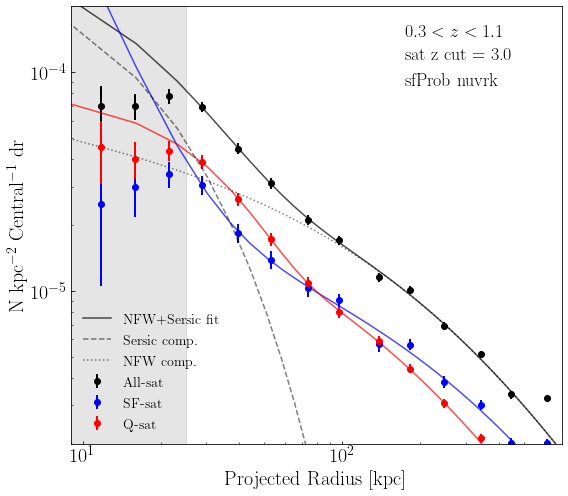

In [12]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))

sfq_method = 'sfProb_nuvrk'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0

path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'
start=4
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)

bin_edges = np.load(path+'bin_centers.npy')
count_radial_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')

########
for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    plt.errorbar(bin_edges, radial[0],radial[1],fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_edges,radial[0],radial[1], 4)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_edges,count_radial_allz[0],count_radial_allz[1], 4)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')

plt.annotate(r'$0.3<z<1.1$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([2e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()
plt.savefig('figures/number_density_allz.png')


### fig.5

split central mass

['ELAIS_deep', 'DEEP_deep', 'COSMOS_deep', 'XMM-LSS_deep']


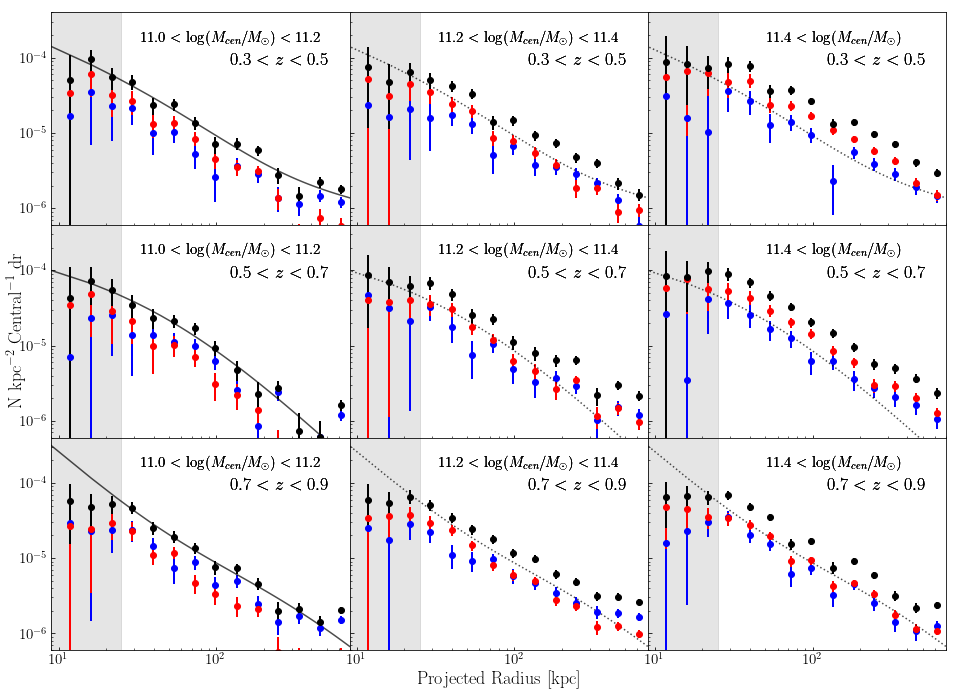

In [23]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(14,10))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

sample_all=''
csfq='all'
sat_z_cut = 3.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
print(field_names)

#============= primary data ===========
path1 = 'CUT_deep_catalogs/radial_dist_code/distribution/split_cen_mass_11.0_11.2/'
path2 = 'CUT_deep_catalogs/radial_dist_code/distribution/split_cen_mass_11.2_11.4/' 
path3 = 'CUT_deep_catalogs/radial_dist_code/distribution/split_cen_mass_11.4_13.0/' 
sample_name1 = r'v8 cat, $M>11.3$, sat z cut  ='+str(sat_z_cut)
bin_edges = np.load(path1+'bin_centers.npy')
colors = ['b','r','k']

for i,z in enumerate([0.4, 0.6, 0.8]):
    for k,ssfq in enumerate(['ssf','sq','all']):
        count_radial_4 = combine_deep_fields(field_names, csfq,ssfq,'9.5','12.0',z,path1,sat_z_cut=sat_z_cut,sample=sample_all)
        count_radial_6 = combine_deep_fields(field_names, csfq,ssfq,'9.5','12.0',z,path2,sat_z_cut=sat_z_cut,sample=sample_all)
        count_radial_8 = combine_deep_fields(field_names, csfq,ssfq,'9.5','12.0',z,path3,sat_z_cut=sat_z_cut,sample=sample_all)
        axs[i][0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='o'+colors[k],linewidth=2)
        axs[i][1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='o'+colors[k],linewidth=2)
        axs[i][2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='o'+colors[k],linewidth=2)
        
        axs[i][0].annotate(r'$11.0<\log(M_{cen}/M_\odot)<11.2$',(0.3,0.85), fontsize=15, xycoords='axes fraction')
        axs[i][1].annotate(r'$11.2<\log(M_{cen}/M_\odot)<11.4$',(0.3,0.85), fontsize=15, xycoords='axes fraction')
        axs[i][2].annotate(r'$11.4<\log(M_{cen}/M_\odot)$',(0.4,0.85), fontsize=15, xycoords='axes fraction')
        axs[i][0].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',(0.6,0.75), fontsize=18, xycoords='axes fraction')
        axs[i][1].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',(0.6,0.75), fontsize=18, xycoords='axes fraction')
        axs[i][2].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',(0.6,0.75), fontsize=18, xycoords='axes fraction')
        
    #========= fitting =====================
    fit_x = np.linspace(2,700,num=100)
    start = 4

    # NFW + Sersic Fitting
    model = 'NFW_Sersic'
    popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
    popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
    popt8,pcov8,chi2_8 = fit_nfw_sersic_fix_n(bin_edges,count_radial_8[0],count_radial_8[1], start)
    perr4 = np.sqrt(np.diag(pcov4))
    perr6 = np.sqrt(np.diag(pcov6))
    perr8 = np.sqrt(np.diag(pcov8))
    popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
    
    #=========== Plot Model ==================
    axs[i][0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
    axs[i][1].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)
    axs[i][2].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)

    axs[i][0].axvspan(9, 25, alpha=0.1, color='k')
    axs[i][1].axvspan(9, 25, alpha=0.1, color='k')
    axs[i][2].axvspan(9, 25, alpha=0.1, color='k')
    axs[i][0].set_xticks([20, 100, 400])
    axs[i][0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i][0].set_xlim([9,700])
    axs[i][0].set_ylim([6e-7,4e-4])
    axs[i][0].set_yscale('log')
    axs[i][0].set_xscale('log')
#     axs[i][0].legend(fontsize=15)
#     axs[i][1].legend(fontsize=15)
#     axs[i][2].legend(fontsize=15)

#=========
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/split_host_mass_sfProb.png')
plt.show() 


### fig.6 
split csfq (allz plot $0.3<z<1.1$)

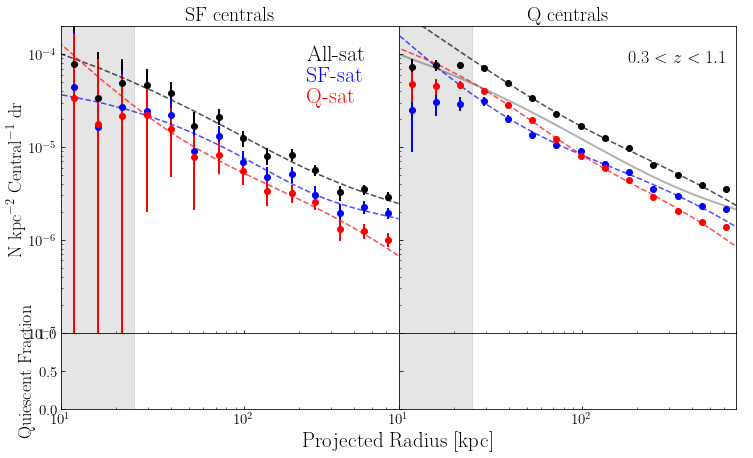

In [29]:
# combine redshift bins
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize = (11, 7),gridspec_kw={'height_ratios':[4,1]})
np.set_printoptions(precision=3)
start=4
sat_z_cut=3.0
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/'
bin_centers = np.load(path+'bin_centers.npy')

for i in range(1):
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    csfqs = ['csf','cq']
    for j in range(2):
        csfq = csfqs[j]
        radial_all = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_9.5_12.0_'+csfq+'_'+ 'all'+'.txt')
        radial_sf = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_9.5_12.0_'+csfq+'_'+ 'ssf'+'.txt')
        radial_q = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_9.5_12.0_'+csfq+'_'+ 'sq'+'.txt')
        red_err = red_frac_err_new(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
#         red_frac = radial_q[0] / radial_all[0]
        
        # plot radial number density profiles
        for radial, color, yloc in [(radial_all,'k',0.21), (radial_sf,'b',0.13), (radial_q,'r',0.05)]:
            axs[i][j].errorbar(bin_centers, radial[0],radial[1],fmt='o',color=color,linewidth=2,label='all')
        
            # model fitting
            fit_x = np.linspace(2,700,num=100)        
            popt,pcov,chi2 = fit_nfw_sersic(bin_centers,radial[0],radial[1], start)
            perr = np.sqrt(np.diag(pcov))
            
            axs[0][j].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'--'+color,alpha=0.7)
            if j==0 and color=='k':
                axs[0][1].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1]*0.85,popt[2],popt[3],popt[4]),color,alpha=0.3,linewidth=2)
        
        # add shaded (non-fitting) region
#         axs[0][j].set_title('central'+radial[2],fontsize=21)
        axs[0][j].axvspan(10, 25, alpha=0.1, color='k')
        axs[1][j].axvspan(10, 25, alpha=0.1, color='k')

#=============================
axs[0][0].set_ylim([1e-7,2e-4])
axs[0][0].set_xlim([10,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[0][0].set_title('SF centrals',fontsize=20)
axs[0][1].set_title('Q centrals',fontsize=20)
axs[1][0].set_ylim([0,1])
axs[1][0].set_ylabel('Quiescent Fraction',fontsize=18)

# print all,sf,q info on figure
axs[0][0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0][0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0][0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')
axs[0][1].annotate(r'$0.3<z<1.1$',xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=21)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_central_sfq_allz.png')
plt.show(); plt.close()

### fig.7

split sat mass

No. of sats, total: 3.96 sf: 3.05 q: 0.91
No. of sats, total: 4.16 sf: 1.58 q: 2.58


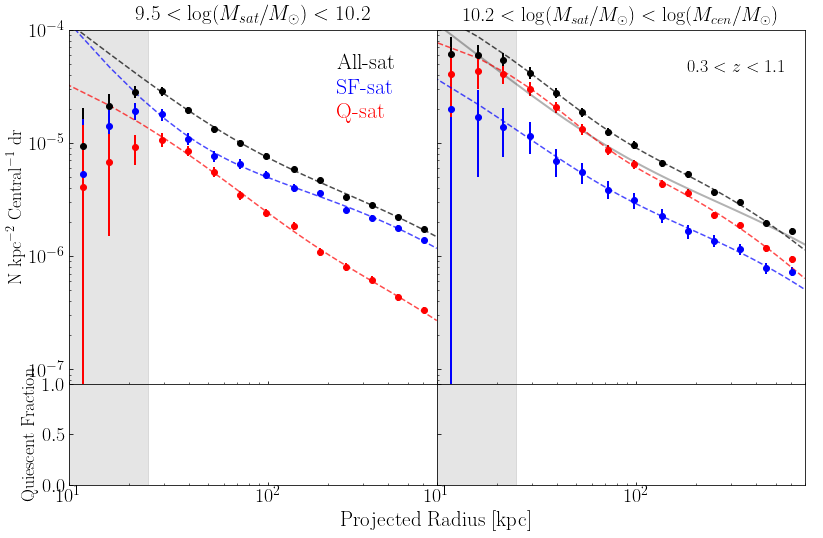

In [17]:
# combine redshift bins
fig, axs = plt.subplots(2, 2, sharex=True, sharey='row', figsize = (12, 8),gridspec_kw={'height_ratios':[3.5,1]})
np.set_printoptions(precision=3)

masscut_low = '9.5'
masscut_high = '10.2'
csfq='all'

start=4
sat_z_cut=3.0
path = 'CUT_deep_catalogs/radial_dist_code/distribution/split_mass_sfProb_nuvrk/'
bin_centers = np.load(path+'bin_centers.npy')

for i in range(1):
    axs[i][0].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=18)
    mass_range = [9.5,10.2,12.0]
    for j in range(2):
        masscut_low = str(mass_range[j])
        masscut_high = str(mass_range[j+1])
        radial_all = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
        radial_sf = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
        radial_q = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')
        red_err = red_frac_err_new(radial_q[0],radial_sf[0],radial_q[1],radial_sf[1])
        red_frac = radial_q[0] / radial_all[0]
        
        print('No. of sats, total:',round(sum(radial_all[0]*areas),2),
              'sf:',round(sum(radial_sf[0]*areas),2),
              'q:',round(sum(radial_q[0]*areas),2))
        
        # plot radial number density profiles
        for radial, color, yloc in [(radial_all,'k',0.21), (radial_sf,'b',0.13), (radial_q,'r',0.05)]:
            axs[i][j].errorbar(bin_centers, radial[0],radial[1],fmt='o',color=color,linewidth=2,label='all')
        
            # model fitting
            fit_x = np.linspace(2,700,num=100)        
            popt,pcov,chi2 = fit_nfw_sersic(bin_centers,radial[0],radial[1], start)
            perr = np.sqrt(np.diag(pcov))
            
            axs[0][j].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'--'+color,alpha=0.7)
            if j==0 and color=='k':
                axs[0][1].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1]*0.85,popt[2],popt[3],popt[4]),color,alpha=0.3,linewidth=2)
        # red fraction
#         axs[1][j].errorbar(bin_centers, red_frac_err, yerr=red_err,color='k')
        
        # add shaded (non-fitting) region
        axs[0][j].axvspan(10, 25, alpha=0.1, color='k')
        axs[1][j].axvspan(10, 25, alpha=0.1, color='k')

#=============================
axs[0][0].set_ylim([7.5e-8,1e-4])
axs[0][0].set_xlim([10,700])
axs[0][0].set_yscale('log')
axs[0][0].set_xscale('log')
axs[1][0].set_ylim([0,1])
axs[1][0].set_ylabel('Quiescent Fraction',fontsize=18)
axs[0][0].set_title('$9.5<\log(M_{sat}/M_\odot)<10.2$',fontsize=21)
axs[0][1].set_title('$10.2<\log(M_{sat}/M_\odot)<\log(M_{cen}/M_\odot)$',fontsize=20)

# print all,sf,q info on figure
axs[0][0].annotate('All-sat',xy=([0.73,0.89]),xycoords='axes fraction',fontsize=22)
axs[0][0].annotate('SF-sat',xy=([0.73,0.82]),xycoords='axes fraction',fontsize=22,color='b')
axs[0][0].annotate('Q-sat',xy=([0.73,0.75]),xycoords='axes fraction',fontsize=22,color='r')
axs[0][1].annotate(r'$0.3<z<1.1$',xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=21)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/splitting_sat_mass_allz.png')
plt.show(); plt.close()


### fig.8

z evo

[134.0, 127.0, 135.0, 191.0]
[125.0, 172.0, 171.0, 319.0]
[437.0, 337.0, 369.0, 516.0]
[410.0, 456.0, 576.0, 528.0]
[169.0, 149.0, 164.0, 222.0]
[174.0, 218.0, 220.0, 405.0]
[700.0, 536.0, 664.0, 707.0]
[671.0, 814.0, 1041.0, 780.0]
[158.0, 151.0, 146.0, 218.0]
[126.0, 168.0, 172.0, 299.0]
[392.0, 302.0, 321.0, 435.0]
[362.0, 400.0, 493.0, 363.0]


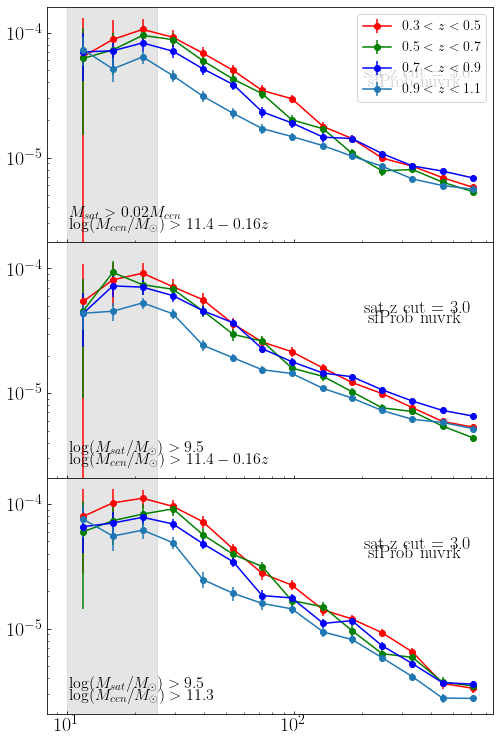

In [20]:
fig, axs = plt.subplots(3, 1, sharex=True,sharey=True, figsize=(8, 13))
sfq_method = 'sfProb_nuvrk'
sat_z_cut = 3.0
field_names =  ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']

########### panel 1: fixed cuts
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'_evo_cenmass/'   # evolving mass cut
bin_centers = np.load(path+'bin_centers.npy')
radial_4 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path)
radial_6 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.6, sat_z_cut=sat_z_cut, path=path)
radial_8 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.8, sat_z_cut=sat_z_cut, path=path)
radial_10 = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.0, sat_z_cut=sat_z_cut, path=path)
axs[0].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
axs[0].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
axs[0].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs[0].errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.9<z<1.1$')
axs[0].annotate('sat z cut = '+str(sat_z_cut),xy=([0.71,0.70]),xycoords='axes fraction',fontsize=18,color='k')
axs[0].annotate(sfq_method.replace('_',' '),xy=([0.72,0.66]),xycoords='axes fraction',fontsize=18,color='k')

axs[0].axhline(2e-5,10,700,linewidth=4, color='r')
axs[0].axvspan(10, 25, alpha=0.1, color='k')
axs[0].legend(fontsize=14)

########### panel 2: z-evo cen mass cut
path =  'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'_evo_cenmass/'  # evolving mass cut
radial_4 = combine_deep_fields(field_names,'all','all','0.02','0.99', 0.4, sat_z_cut=sat_z_cut, path=path)
radial_6 = combine_deep_fields(field_names,'all','all','0.02','0.99', 0.6, sat_z_cut=sat_z_cut, path=path)
radial_8 = combine_deep_fields(field_names,'all','all','0.02','0.99', 0.8, sat_z_cut=sat_z_cut, path=path)
radial_10 = combine_deep_fields(field_names,'all','all','0.02','0.99', 1.0, sat_z_cut=sat_z_cut, path=path)
axs[1].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
axs[1].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
axs[1].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs[1].errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.9<z<1.1$')
axs[1].annotate('sat z cut = '+str(sat_z_cut),xy=([0.71,0.70]),xycoords='axes fraction',fontsize=18,color='k')
axs[1].annotate(sfq_method.replace('_',' '),xy=([0.72,0.66]),xycoords='axes fraction',fontsize=18,color='k')
axs[1].axhline(2e-5,10,700,linewidth=4, color='r')
axs[1].axvspan(10, 25, alpha=0.1, color='k')

########### panel 3: z-evo cen/sat mass cut
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'  # evolving mass cut
radial_4 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path)
radial_6 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.6, sat_z_cut=sat_z_cut, path=path)
radial_8 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.8, sat_z_cut=sat_z_cut, path=path)
radial_10 = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.0, sat_z_cut=sat_z_cut, path=path)
axs[2].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
axs[2].errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
axs[2].errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs[2].errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.9<z<1.1$')
axs[2].annotate(sfq_method.replace('_',' '),xy=([0.72,0.66]),xycoords='axes fraction',fontsize=18,color='k')
axs[2].axhline(2e-5,10,700,linewidth=4, color='r')
axs[2].axvspan(10, 25, alpha=0.1, color='k')

# annotations
axs[2].annotate('$\log(M_{cen}/M_\odot)>11.3$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$\log(M_{cen}/M_\odot)>11.4-0.16z$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[0].annotate('$\log(M_{cen}/M_\odot)>11.4-0.16z$',xy=([0.05,0.05]),xycoords='axes fraction',fontsize=16,color='k')
axs[2].annotate('$\log(M_{sat}/M_\odot)>9.5$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[1].annotate('$\log(M_{sat}/M_\odot)>9.5$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')
axs[0].annotate('$M_{sat}>0.02M_{cen}$',xy=([0.05,0.1]),xycoords='axes fraction',fontsize=16,color='k')

plt.xscale('log')
plt.yscale('log')
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/radial_evolution_all_cuts.png')

### fig.9
z-evo plot for low/high mass satellites

/Users/lejay/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6649: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


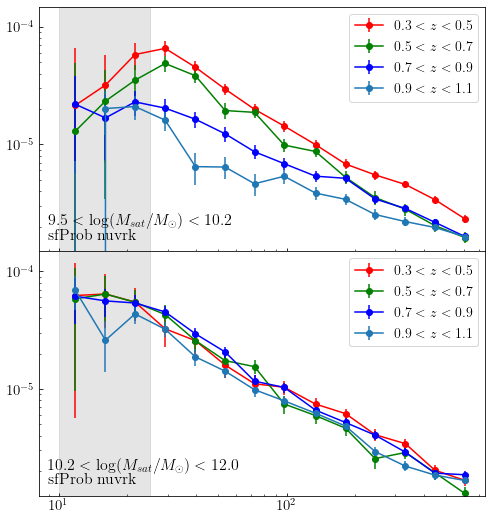

In [61]:
fig, axs = plt.subplots(2, 1, sharex=True,sharey=True, figsize=(8, 9))
path = 'CUT_deep_catalogs/radial_dist_code/distribution/split_mass_sfProb_nuvrk/'
sfq_method = 'sfProb_nuvrk'

sat_z_cut = 3.0
bin_centers = np.load(path+'bin_centers.npy')
masscut_lows = ['9.5','10.2']
masscut_highs = ['10.2','12.0']
colors = ['r','g','b','']
for i in range(2):
    for k,z in enumerate([0.4,0.6,0.8,1.0]):
        radial_4 = combine_deep_fields(field_names,'all','all',masscut_lows[i],masscut_highs[i], z, sat_z_cut=sat_z_cut, path=path)
    
        axs[i].errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='o'+colors[k]+'-',
                        label=r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$')
    axs[i].annotate(sfq_method.replace('_',' '),xy=([0.02,0.05]),xycoords='axes fraction',fontsize=16,color='k')
    axs[i].annotate('$'+masscut_lows[i]+'<\log(M_{sat}/M_\odot)<'+masscut_highs[i]+'$',xy=([0.02,0.1]),xycoords='axes fraction',fontsize=16,color='k')
    
    axs[i].axhline(2e-5,10,700,linewidth=4, color='r')
    axs[i].axvspan(10, 25, alpha=0.1, color='k')
    axs[i].legend(fontsize=14)
    plt.xscale('log')
    plt.yscale('log')

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

### Split z-bin Figures

all mass / sfr

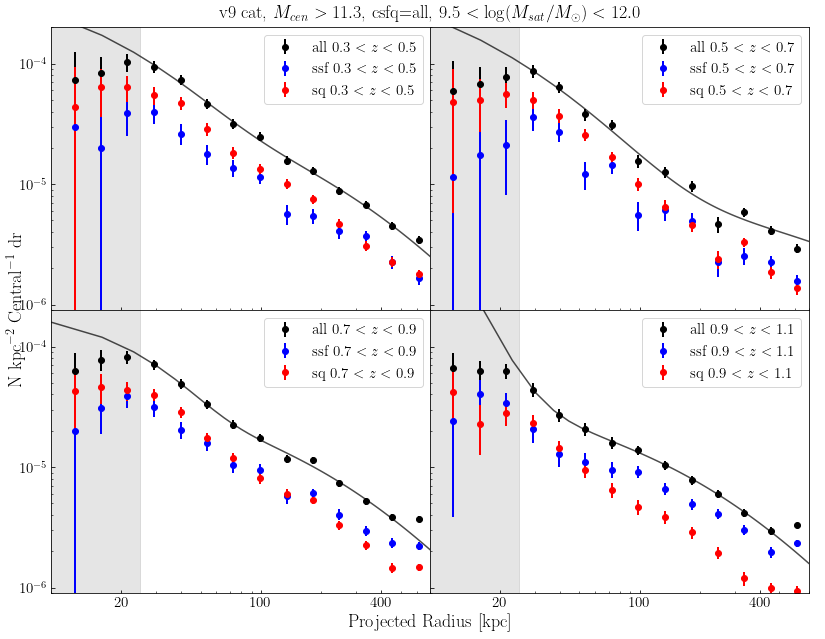

In [58]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,9))
sample_all=''
csfq='all'
sat_z_cut = 3.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
colors = ['k','b','r']
#============= primary data ===========
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/' 
sample_name = r'v9 cat, $M_{cen}>11.3$, csfq='+csfq+', $9.5<\log(M_{sat}/M_\odot)<12.0$'

for i,z in enumerate([0.4,0.6,0.8,1.0]):
    row = i // 2; col = i % 2
    for k,ssfq in enumerate(['all','ssf','sq']):
        count_radial = combine_deep_fields(field_names, csfq,ssfq,'9.5','12.0',z,path,sat_z_cut=sat_z_cut,sample=sample_all)
        bin_edges = np.load(path+'bin_centers.npy')
        #==============plot====================
        axs[row][col].errorbar(bin_edges, count_radial[0],count_radial[1],fmt='o'+colors[k],
                           label=ssfq+' $'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',linewidth=2)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xscale('log')
        if ssfq == 'all':  #========= NFW + Sersic Fitting =====================
            fit_x = np.linspace(2,700,num=100); start = 4; model = 'NFW_Sersic'
            popt,pcov,chi2 = fit_nfw_sersic(bin_edges,count_radial[0],count_radial[1], start)
            perr = np.sqrt(np.diag(pcov))
            #=========== Plot Model ==================
            axs[row][col].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'k',alpha=0.7)
    
    axs[row][col].axvspan(9, 25, alpha=0.1, color='k')
    axs[row][col].legend(fontsize=15)
    axs[row][col].set_xticks([20, 100, 400])
    axs[row][col].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[row][col].set_xlim([9,700])
    axs[row][col].set_ylim([9e-7,2e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
plt.title(sample_name,fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 

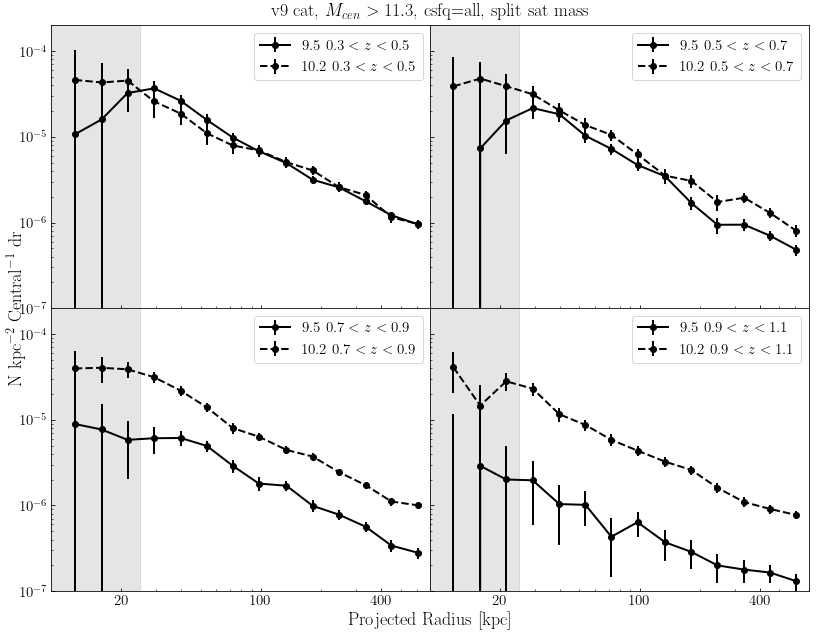

In [66]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,9))
sample_all=''
csfq='all'
sat_z_cut = 3.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
linestyles = ['-','--']
#============= primary data ===========
path = path = 'CUT_deep_catalogs/radial_dist_code/distribution/split_mass_sfProb_nuvrk/'
sample_name = r'v9 cat, $M_{cen}>11.3$, csfq='+csfq+', split sat mass'
masscut_lows = ['9.5','10.2']
masscut_highs = ['10.2','12.0']

for i,z in enumerate([0.4,0.6,0.8,1.0]):
    row = i // 2; col = i % 2
    for k in range(2):
        count_radial = combine_deep_fields(field_names, csfq,ssfq,masscut_lows[k],masscut_highs[k],z,path,sat_z_cut=sat_z_cut,sample=sample_all)
        bin_edges = np.load(path+'bin_centers.npy')
        #==============plot====================
        axs[row][col].errorbar(bin_edges, count_radial[0],count_radial[1],fmt='ok'+linestyles[k],
                           label=masscut_lows[k]+' $'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',linewidth=2)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xscale('log')
        if ssfq == 'all':  #========= NFW + Sersic Fitting =====================
            fit_x = np.linspace(2,700,num=100); start = 4; model = 'NFW_Sersic'
            popt,pcov,chi2 = fit_nfw_sersic(bin_edges,count_radial[0],count_radial[1], start)
            perr = np.sqrt(np.diag(pcov))
            #=========== Plot Model ==================
            axs[row][col].plot(fit_x,nfw_sersic(fit_x, popt[0],popt[1],popt[2],popt[3],popt[4]),'k',alpha=0.7)
    
    axs[row][col].axvspan(9, 25, alpha=0.1, color='k')
    axs[row][col].legend(fontsize=15)
    axs[row][col].set_xticks([20, 100, 400])
    axs[row][col].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[row][col].set_xlim([9,700])
    axs[row][col].set_ylim([1e-7,2e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
plt.title(sample_name,fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 

### Comparison Figures

#### compare with old catalog

['ELAIS_deep', 'DEEP_deep', 'COSMOS_deep', 'XMM-LSS_deep']
fitting NFW+Sersic
dof: 6
--------all---------
[3.008e+02 2.048e-05 4.387e-05 3.398e+01 6.180e-01] [7.149e+01 5.528e-06 1.534e-05 6.216e+00 5.284e-01] Chi2_dof=0.86
[2.886e+03 2.165e-06 1.712e-06 3.000e+02 6.664e+00] [3.138e+04 1.814e-05 6.861e-05 7.389e+03 6.376e+01] Chi2_dof=1.07
[6.262e+02 9.155e-06 3.617e-05 3.459e+01 2.610e-01] [1.726e+02 2.346e-06 1.111e-05 6.774e+00 2.499e-01] Chi2_dof=4.31


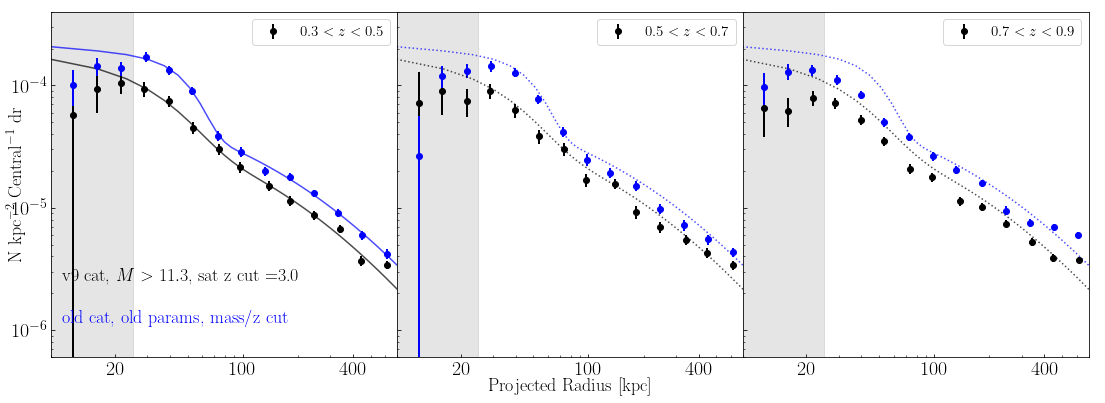

In [24]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

sample_all=''
csfq='all'
sat_z_cut = 3.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
print(field_names)

#============= primary data ===========
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/' 
sample_name1 = r'v9 cat, $M>11.3$, sat z cut  ='+str(sat_z_cut)

bin_edges = np.load(path+'bin_centers.npy')
count_radial_4 = combine_deep_fields(field_names, csfq,'all','9.5','12.0',0.4,path,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_6 = combine_deep_fields(field_names, csfq,'all','9.5','12.0',0.6,path,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_8 = combine_deep_fields(field_names, csfq,'all','9.5','12.0',0.8,path,sat_z_cut=sat_z_cut,sample=sample_all)

# ============ secondary data ============
path2 = 'CUT_deep_catalogs/total_sample_0330/'
sample_name2 = 'old cat, old params, mass/z cut'

bin_edges2 = np.load(path2+'bin_centers.npy')
count_radial_4_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.4,path2,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_6_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.6,path2,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_8_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.8,path2,sat_z_cut=sat_z_cut,sample=sample_all)

#==============plot====================
axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label=r'$0.3<z<0.5$',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label=r'$0.5<z<0.7$',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label=r'$0.7<z<0.9$',linewidth=2)

axs[0].errorbar(bin_edges2, count_radial_4_2[0],count_radial_4_2[1],fmt='ob',linewidth=2)
axs[1].errorbar(bin_edges2, count_radial_6_2[0],count_radial_6_2[1],fmt='ob',linewidth=2)
axs[2].errorbar(bin_edges2, count_radial_8_2[0],count_radial_8_2[1],fmt='ob',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

#========= fitting =====================
fit_x = np.linspace(2,700,num=100)
start = 4

# NFW + Sersic Fitting
print('fitting NFW+Sersic')
model = 'NFW_Sersic'
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
popt8,pcov8,chi2_8 = fit_nfw_sersic_fix_n(bin_edges,count_radial_8[0],count_radial_8[1], start)
perr4 = np.sqrt(np.diag(pcov4))
perr6 = np.sqrt(np.diag(pcov6))
perr8 = np.sqrt(np.diag(pcov8))
popt42,pcov42,chi2_42 = fit_nfw_sersic(bin_edges,count_radial_4_2[0],count_radial_4_2[1], start)

#=========== Plot Model ==================
axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)

axs[0].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),'b',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),':b',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),':b',alpha=0.7)

np.set_printoptions(precision=3)
dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom
print('dof:',dof)
print('--------all---------')
print(popt4,perr4,'Chi2_dof='+str(round(chi2_4/dof,2)))
print(popt6,perr6,'Chi2_dof='+str(round(chi2_6/dof,2)))
print(popt8,perr8,'Chi2_dof='+str(round(chi2_8/dof,2)))

# print all,sf,q info on figure
axs[0].annotate(sample_name1,xy=([0.03,0.22]),xycoords='axes fraction',fontsize=18)
axs[0].annotate(sample_name2,xy=([0.03,0.10]),xycoords='axes fraction',fontsize=18,color='b')

#=========
axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')
axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([6e-7,4e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 

#### compare sat_z_cut

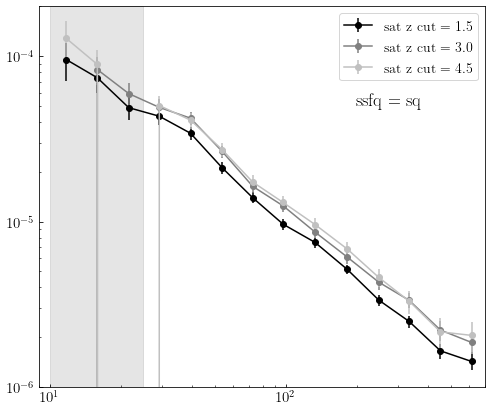

In [170]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))

# panel 1
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/'  # evolving mass cut
ssfq = 'sq'
bin_centers = np.load(path+'bin_centers.npy')

# split z
# radial_15 = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', 0.4,sat_z_cut=1.5, path=path)
# radial_30 = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', 0.4,sat_z_cut=3.0, path=path)
# radial_45 = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', 0.4,sat_z_cut=4.5, path=path)

# all z
radial_15 = np.loadtxt(path+'all_field_1.5_'+masscut_low+'_'+masscut_high+'_'+ 'all'+'_'+ssfq+'.txt')
radial_30 = np.loadtxt(path+'all_field_3.0_'+masscut_low+'_'+masscut_high+'_'+ 'all'+'_'+ssfq+'.txt')
radial_45 = np.loadtxt(path+'all_field_4.5_'+masscut_low+'_'+masscut_high+'_'+ 'all'+'_'+ssfq+'.txt')

plt.errorbar(bin_centers, radial_15[0],yerr=radial_15[1],fmt='o-',color='black',label='sat z cut = 1.5')
plt.errorbar(bin_centers, radial_30[0],yerr=radial_30[1],fmt='o-',color='gray',label='sat z cut = 3.0')
plt.errorbar(bin_centers, radial_45[0],yerr=radial_45[1],fmt='o-',color='silver',label='sat z cut = 4.5')
plt.annotate('ssfq = '+ssfq,xy=([0.71,0.74]),xycoords='axes fraction',fontsize=18,color='k')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xscale('log')
plt.yscale('log')

#### compare sfq_method

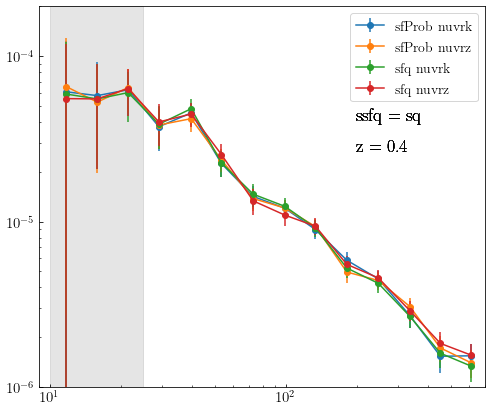

In [212]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
sfq_methods = ['sfProb_nuvrk','sfProb_nuvrz','sfq_nuvrk','sfq_nuvrz']
ssfq = 'sq'
bin_centers = np.load(path+'bin_centers.npy')
z = 0.4

for sfq_method in sfq_methods:
    path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'  # evolving mass cut
    radial = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', z,sat_z_cut=1.5, path=path)
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',label=sfq_method.replace('_',' '))
    plt.annotate('ssfq = '+ssfq,xy=([0.71,0.70]),xycoords='axes fraction',fontsize=18,color='k')
    plt.annotate('z = '+str(z),xy=([0.71,0.62]),xycoords='axes fraction',fontsize=18,color='k')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xscale('log')
plt.yscale('log')

#### compare cen mass cut

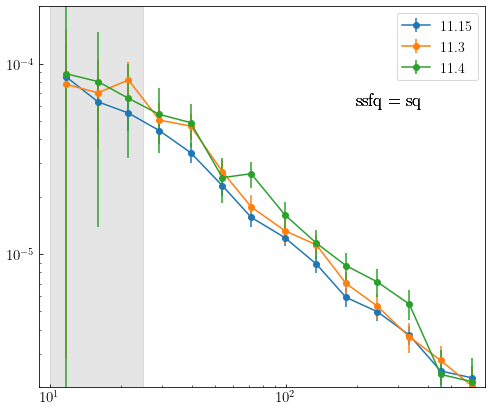

In [351]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
cen_mass_limits = [11.15,11.3,11.4]
cen_mass_limits_names = ['cenmass_1115','cenmass_113','cenmass_114']
ssfq = 'sq'
bin_centers = np.load(path+'bin_centers.npy')


for i,cen_mass_limit in enumerate(cen_mass_limits):
    path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+cen_mass_limits_names[i]+'/'  # evolving mass cut
    radial = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', 0.4, sat_z_cut=3.0, path=path)
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',label=str(cen_mass_limit))
    plt.annotate('ssfq = '+ssfq,xy=([0.71,0.74]),xycoords='axes fraction',fontsize=18,color='k')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([2e-6,2e-4])
plt.xscale('log')
plt.yscale('log')

### check plots

##### sat_z_cut==30
essentailly no redshift selection for satellites

['ELAIS_deep', 'DEEP_deep', 'COSMOS_deep', 'XMM-LSS_deep']
fitting NFW+Sersic


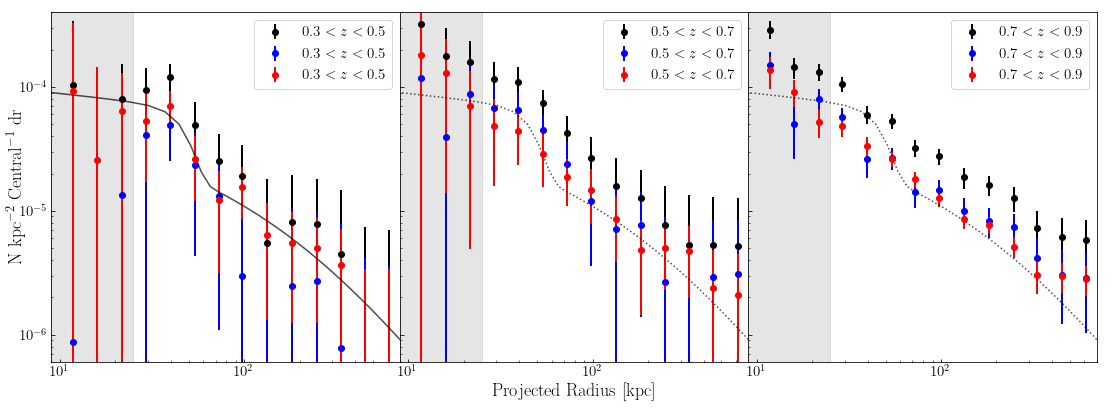

In [200]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

sample_all=''
csfq='all'
sat_z_cut = 30.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
print(field_names)

#============= primary data ===========
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/' 
sample_name1 = r'v8 cat, $M>11.3$, sat z cut  ='+str(sat_z_cut)

bin_edges = np.load(path+'bin_centers.npy')

colors = ['k','b','r']
for k,ssfq in enumerate(['all','ssf','sq']):
    count_radial_4 = combine_deep_fields(field_names, csfq,ssfq,'9.5','12.0',0.4,path,sat_z_cut=sat_z_cut,sample=sample_all)
    count_radial_6 = combine_deep_fields(field_names, csfq,ssfq,'9.5','12.0',0.6,path,sat_z_cut=sat_z_cut,sample=sample_all)
    count_radial_8 = combine_deep_fields(field_names, csfq,ssfq,'9.5','12.0',0.8,path,sat_z_cut=sat_z_cut,sample=sample_all)
    axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='o'+colors[k],label=r'$0.3<z<0.5$',linewidth=2)
    axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='o'+colors[k],label=r'$0.5<z<0.7$',linewidth=2)
    axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='o'+colors[k],label=r'$0.7<z<0.9$',linewidth=2)

#========= fitting =====================
fit_x = np.linspace(2,700,num=100)
start = 4

# NFW + Sersic Fitting
print('fitting NFW+Sersic')
model = 'NFW_Sersic'
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
popt8,pcov8,chi2_8 = fit_nfw_sersic_fix_n(bin_edges,count_radial_8[0],count_radial_8[1], start)
perr4 = np.sqrt(np.diag(pcov4))
perr6 = np.sqrt(np.diag(pcov6))
perr8 = np.sqrt(np.diag(pcov8))
popt42,pcov42,chi2_42 = fit_nfw_sersic(bin_edges,count_radial_4_2[0],count_radial_4_2[1], start)

#=========== Plot Model ==================
axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)

#=========
axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axs[0].set_xlim([9,700])
axs[0].set_ylim([6e-7,4e-4])
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 

#### high-z objects only

sat_z_cut = 'highz' (z>2)

9.5-12.0

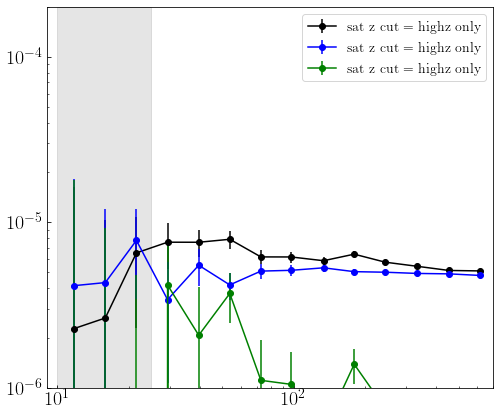

In [18]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
ssfq = 'all'
bin_centers = np.load(path+'bin_centers.npy')
sfq_method = 'sfProb_nuvrk'
z=0.8
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'  # evolving mass cut
    
radial = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', z, sat_z_cut='highz',sample='sat', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='black',label='sat z cut = highz only')

radial = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', z, sat_z_cut='highz',sample='bkg', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='blue',label='sat z cut = highz only')

radial = combine_deep_fields(field_names,'all',ssfq,'9.5','12.0', z, sat_z_cut='highz',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='green',label='sat z cut = highz only')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xscale('log')
plt.yscale('log')


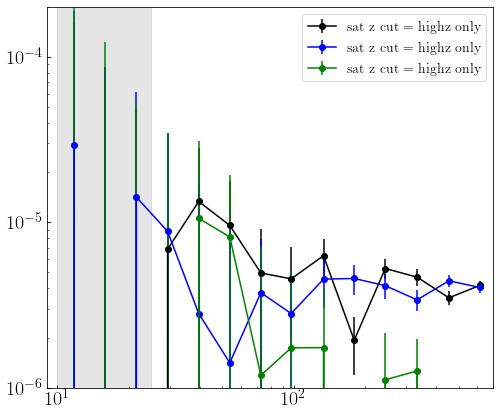

In [25]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
ssfq = 'all'
# bin_centers = np.load(path+'bin_centers.npy')
sfq_method = 'CLASS'
z=0.8
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_cosmos2020_'+sfq_method+'/'  # evolving mass cut
    
radial = combine_deep_fields(['COSMOS_deep'],'all',ssfq,'9.5','12.0', z, sat_z_cut='highz',sample='sat', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='black',label='sat z cut = highz only')

radial = combine_deep_fields(['COSMOS_deep'],'all',ssfq,'9.5','12.0', z, sat_z_cut='highz',sample='bkg', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='blue',label='sat z cut = highz only')

radial = combine_deep_fields(['COSMOS_deep'],'all',ssfq,'9.5','12.0', z, sat_z_cut='highz',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='green',label='sat z cut = highz only')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xscale('log')
plt.yscale('log')

#### 0.9-1.1 redshift bin

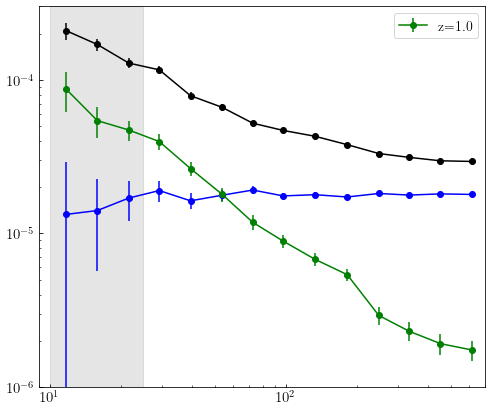

In [277]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
bin_centers = np.load(path+'bin_centers.npy')
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/' 
    
radial = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.0, sat_z_cut='3.0',sample='sat', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='black')

radial = combine_deep_fields(field_names,'all','ssf','9.5','12.0', 1.0, sat_z_cut='3.0',sample='bkg', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='blue')

radial = combine_deep_fields(field_names,'all','sq','9.5','12.0', 1.0, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='green',label='z=1.0')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
plt.xscale('log')
plt.yscale('log')


#### no central count error

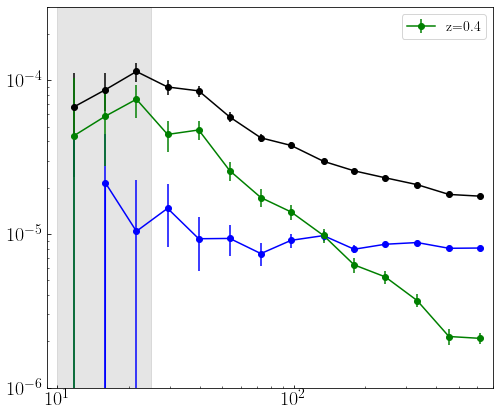

In [27]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
bin_centers = np.load(path+'bin_centers.npy')
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'_test_error/' 
z=0.4

radial = combine_deep_fields(field_names,'all','all','9.5','12.0', z, sat_z_cut='3.0',sample='sat', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='black')

radial = combine_deep_fields(field_names,'all','ssf','9.5','12.0', z, sat_z_cut='3.0',sample='bkg', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='blue')

radial = combine_deep_fields(field_names,'all','sq','9.5','12.0', z, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='green',label='z='+str(z))

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
plt.xscale('log')
plt.yscale('log')


#### relative satellite mass cut
0.02 to 0.99 cen mass

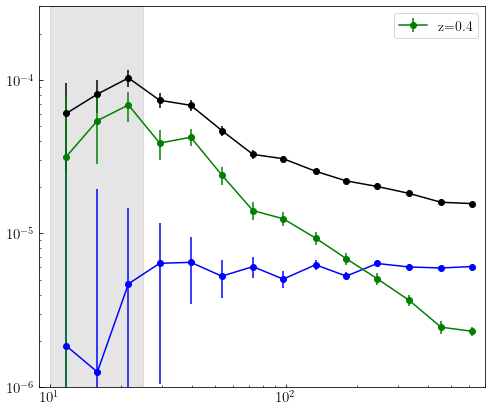

In [360]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
bin_centers = np.load(path+'bin_centers.npy')
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'_test_error/' 
z=0.4

radial = combine_deep_fields(field_names,'all','all','0.02','0.99', z, sat_z_cut='3.0',sample='sat', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='black')

radial = combine_deep_fields(field_names,'all','ssf','0.02','0.99', z, sat_z_cut='3.0',sample='bkg', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='blue')

radial = combine_deep_fields(field_names,'all','sq','0.02','0.99', z, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='green',label='z='+str(z))

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
plt.xscale('log')
plt.yscale('log')


#### Moving Central Mass Cut
M>11.4-0.16z

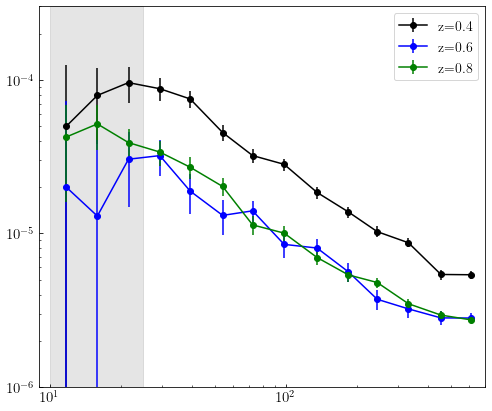

In [60]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
bin_centers = np.load(path+'bin_centers.npy')
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'_evo_cenmass/' 

radial = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='black',label='z=0.4')

radial = combine_deep_fields(field_names,'all','ssf','9.5','12.0', 0.6, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='blue',label='z=0.6')

radial = combine_deep_fields(field_names,'all','sq','9.5','12.0', 0.8, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='green',label='z=0.8')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
plt.xscale('log')
plt.yscale('log')




#### Moving Central Mass Cut
M>11.4-0.16z

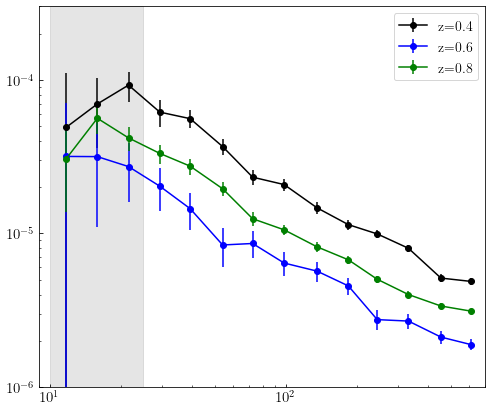

In [59]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
bin_centers = np.load(path+'bin_centers.npy')
sfq_method = 'sfProb_nuvrk'
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'_evo_cenmass/' 

radial = combine_deep_fields(field_names,'all','all','0.02','0.99', 0.4, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='black',label='z=0.4')

radial = combine_deep_fields(field_names,'all','ssf','0.02','0.99', 0.6, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='blue',label='z=0.6')

radial = combine_deep_fields(field_names,'all','sq','0.02','0.99', 0.8, sat_z_cut='3.0',sample='', path=path)
plt.errorbar(bin_centers, radial[0],yerr=radial[1],fmt='o-',color='green',label='z=0.8')
            

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
plt.xscale('log')
plt.yscale('log')


#### COSMOS2020 check result

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


['ELAIS_deep', 'DEEP_deep', 'COSMOS_deep', 'XMM-LSS_deep']
fitting NFW+Sersic
dof: 6
--------all---------
[1.635e+02 3.737e-05 8.172e-05 3.583e+01 2.982e-01] [1.562e+02 4.691e-05 6.487e-05 1.061e+01 5.751e-01] Chi2_dof=0.86
[1.000e+04 1.851e-06 8.285e-05 4.208e+01 3.302e-01] [5.399e+04 3.210e-06 4.605e-05 8.841e+00 4.726e-01] Chi2_dof=0.69
[3.564e+02 2.236e-05 1.020e-05 1.590e+01 2.604e-01] [1.035e+02 6.775e-06 8.077e-04 3.004e+00 6.172e+01] Chi2_dof=0.79


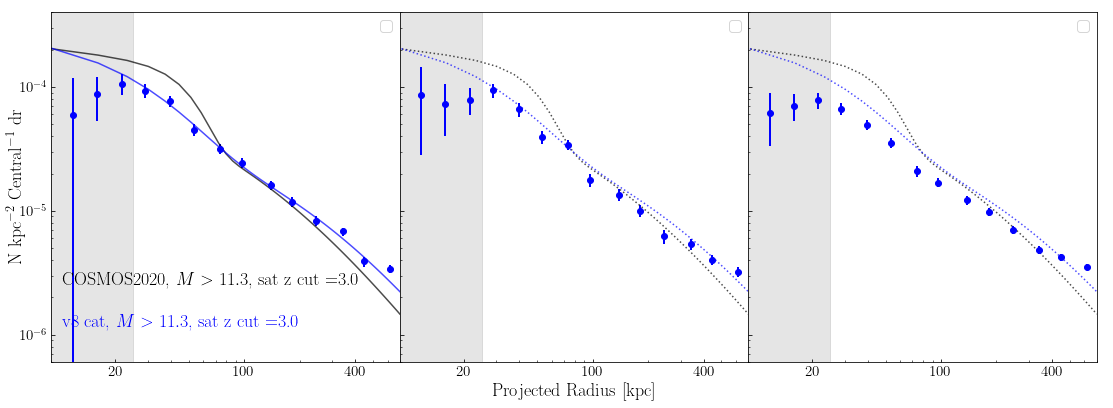

In [89]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

sample_all=''
csfq='all'
sat_z_cut = 3.0
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
print(field_names)

#============= primary data ===========
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_cosmos2020_CLASS/' 
sample_name1 = r'COSMOS2020, $M>11.3$, sat z cut  ='+str(sat_z_cut)

bin_edges = np.load(path+'bin_centers.npy')
count_radial_4 = combine_deep_fields(['COSMOS_deep'], csfq,'all','9.5','12.0',0.4,path,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_6 = combine_deep_fields(['COSMOS_deep'], csfq,'all','9.5','12.0',0.6,path,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_8 = combine_deep_fields(['COSMOS_deep'], csfq,'all','9.5','12.0',0.8,path,sat_z_cut=sat_z_cut,sample=sample_all)

# ============ secondary data ============
path2 = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_sfProb_nuvrk/' 
sample_name2 = r'v8 cat, $M>11.3$, sat z cut  ='+str(sat_z_cut)

bin_edges2 = np.load(path2+'bin_centers.npy')
count_radial_4_2 = combine_deep_fields(field_names, csfq,'all','9.5','12.0',0.4,path2,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_6_2 = combine_deep_fields(field_names, csfq,'all','9.5','12.0',0.6,path2,sat_z_cut=sat_z_cut,sample=sample_all)
count_radial_8_2 = combine_deep_fields(field_names, csfq,'all','9.5','12.0',0.8,path2,sat_z_cut=sat_z_cut,sample=sample_all)

#==============plot====================
# axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label=r'$0.3<z<0.5$',linewidth=2)
# axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label=r'$0.5<z<0.7$',linewidth=2)
# axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label=r'$0.7<z<0.9$',linewidth=2)
axs[0].errorbar(bin_edges2, count_radial_4_2[0],count_radial_4_2[1],fmt='ob',linewidth=2)
axs[1].errorbar(bin_edges2, count_radial_6_2[0],count_radial_6_2[1],fmt='ob',linewidth=2)
axs[2].errorbar(bin_edges2, count_radial_8_2[0],count_radial_8_2[1],fmt='ob',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

#========= fitting =====================
fit_x = np.linspace(2,700,num=100)
start = 4

# NFW + Sersic Fitting
print('fitting NFW+Sersic')
model = 'NFW_Sersic'
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
popt8,pcov8,chi2_8 = fit_nfw_sersic_fix_n(bin_edges,count_radial_8[0],count_radial_8[1], start)
perr4 = np.sqrt(np.diag(pcov4))
perr6 = np.sqrt(np.diag(pcov6))
perr8 = np.sqrt(np.diag(pcov8))
popt42,pcov42,chi2_42 = fit_nfw_sersic(bin_edges,count_radial_4_2[0],count_radial_4_2[1], start)

#=========== Plot Model ==================
axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)

axs[0].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),'b',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),':b',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),':b',alpha=0.7)

np.set_printoptions(precision=3)
dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom
print('dof:',dof)
print('--------all---------')
print(popt4,perr4,'Chi2_dof='+str(round(chi2_4/dof,2)))
print(popt6,perr6,'Chi2_dof='+str(round(chi2_6/dof,2)))
print(popt8,perr8,'Chi2_dof='+str(round(chi2_8/dof,2)))

# print all,sf,q info on figure
axs[0].annotate(sample_name1,xy=([0.03,0.22]),xycoords='axes fraction',fontsize=18)
axs[0].annotate(sample_name2,xy=([0.03,0.10]),xycoords='axes fraction',fontsize=18,color='b')

#=========
axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')
axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([6e-7,4e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.show() 

#### bkg level

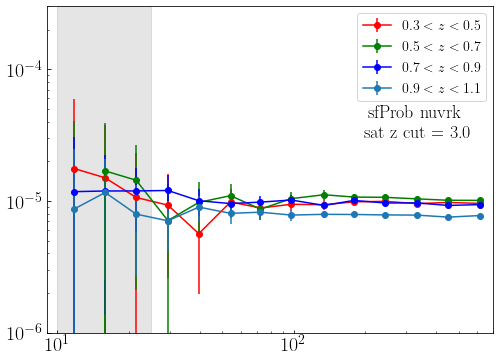

In [36]:
# z_evo plot
fig, axs = plt.subplots(1, 1, sharex=True,sharey=True, figsize=(8, 6))
sfq_method = 'sfProb_nuvrk'
sat_z_cut = 3.0
sample_all = 'bkg'

field_names = ['COSMOS_deep','XMM-LSS_deep','DEEP_deep','ELAIS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'  # evolving mass cut
radial_4 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path,sample=sample_all)
radial_6 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.6, sat_z_cut=sat_z_cut, path=path,sample=sample_all)
radial_8 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.8, sat_z_cut=sat_z_cut, path=path,sample=sample_all)
radial_10 = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.0, sat_z_cut=sat_z_cut, path=path,sample=sample_all)

axs.errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
axs.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
axs.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs.errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.9<z<1.1$')
axs.annotate('sat z cut = '+str(sat_z_cut),xy=([0.71,0.60]),xycoords='axes fraction',fontsize=18,color='k')
axs.annotate(sfq_method.replace('_',' '),xy=([0.72,0.66]),xycoords='axes fraction',fontsize=18,color='k')
axs.axhline(2e-5,10,700,linewidth=4, color='r')
axs.axvspan(10, 25, alpha=0.1, color='k')

plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
axs.set_xscale('log')
axs.set_yscale('log')

#### inside_J
only part of COSMOS and XMM

[146.0, 218.0]
[172.0, 299.0]
[321.0, 435.0]
[493.0, 363.0]
[343.0, 519.0]


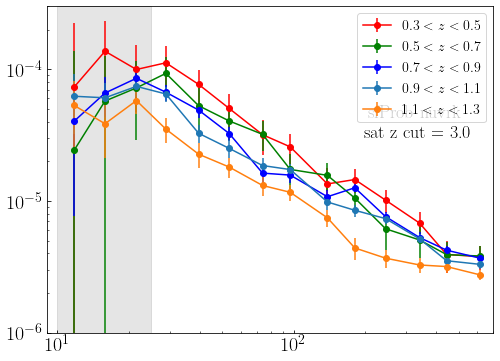

In [8]:
# z_evo plot
fig, axs = plt.subplots(1, 1, sharex=True,sharey=True, figsize=(8, 6))
sfq_method = 'sfProb_nuvrk'
sat_z_cut = 3.0
sample_all = ''

field_names = ['COSMOS_deep','XMM-LSS_deep']
path = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'  # evolving mass cut
bin_centers = np.load(path+'bin_centers.npy')

radial_4 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.4, sat_z_cut=sat_z_cut, path=path,sample=sample_all)
radial_6 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.6, sat_z_cut=sat_z_cut, path=path,sample=sample_all)
radial_8 = combine_deep_fields(field_names,'all','all','9.5','12.0', 0.8, sat_z_cut=sat_z_cut, path=path,sample=sample_all)
radial_10 = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.0, sat_z_cut=sat_z_cut, path=path,sample=sample_all)
radial_12 = combine_deep_fields(field_names,'all','all','9.5','12.0', 1.2, sat_z_cut=sat_z_cut, path=path,sample=sample_all)

axs.errorbar(bin_centers, radial_4[0],yerr=radial_4[1]*np.sqrt(5),fmt='or-',label='$0.3<z<0.5$')
axs.errorbar(bin_centers, radial_6[0],yerr=radial_6[1]*np.sqrt(5),fmt='og-',label='$0.5<z<0.7$')
axs.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')
axs.errorbar(bin_centers, radial_10[0],yerr=radial_10[1],fmt='o-',label='$0.9<z<1.1$')
axs.errorbar(bin_centers, radial_12[0],yerr=radial_12[1],fmt='o-',label='$1.1<z<1.3$')
axs.annotate('sat z cut = '+str(sat_z_cut),xy=([0.71,0.60]),xycoords='axes fraction',fontsize=18,color='k')
axs.annotate(sfq_method.replace('_',' '),xy=([0.72,0.66]),xycoords='axes fraction',fontsize=18,color='k')
axs.axhline(2e-5,10,700,linewidth=4, color='r')
axs.axvspan(10, 25, alpha=0.1, color='k')

plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
axs.set_xscale('log')
axs.set_yscale('log')

[343.0, 519.0]
[58.0, 139.0]


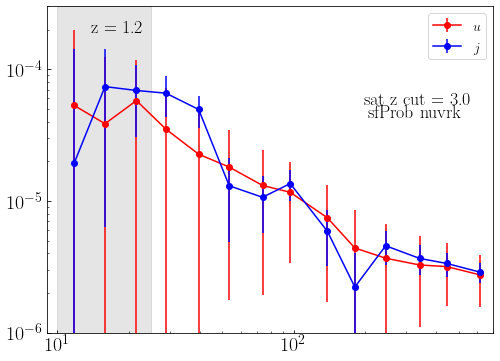

In [10]:
# z_evo plot
fig, axs = plt.subplots(1, 1, sharex=True,sharey=True, figsize=(8, 6))
sfq_method = 'sfProb_nuvrk'
sat_z_cut = 3.0
z=1.2
sample_all = ''


field_names = ['COSMOS_deep','XMM-LSS_deep']
path1 = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'/'  # evolving mass cut
path2 = 'CUT_deep_catalogs/radial_dist_code/distribution/total_sample_'+sfq_method+'_inside_j/'  # evolving mass cut
bin_centers = np.load(path1+'bin_centers.npy')

radial_4 = combine_deep_fields(field_names,'all','all','9.5','12.0', z, sat_z_cut=sat_z_cut, path=path1,sample=sample_all)
radial_6 = combine_deep_fields(field_names,'all','all','9.5','12.0', z, sat_z_cut=sat_z_cut, path=path2,sample=sample_all)

axs.errorbar(bin_centers, radial_4[0],yerr=radial_4[1]*5,fmt='or-',label='$u$')
axs.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='ob-',label='$j$')
axs.annotate('sat z cut = '+str(sat_z_cut),xy=([0.71,0.70]),xycoords='axes fraction',fontsize=18,color='k')
axs.annotate(sfq_method.replace('_',' '),xy=([0.72,0.66]),xycoords='axes fraction',fontsize=18,color='k')
axs.annotate('z  = '+str(z),xy=([0.1,0.92]),xycoords='axes fraction',fontsize=18,color='k')
axs.axhline(2e-5,10,700,linewidth=4, color='r')
axs.axvspan(10, 25, alpha=0.1, color='k')

plt.legend(fontsize=14)
plt.xlim([9,700])
plt.ylim([1e-6,3e-4])
axs.set_xscale('log')
axs.set_yscale('log')
